
# Embedding Visualization

This script demonstrates how to:
1. Load a trained autoencoder model
2. Run inference to compute embeddings (latent representations)
3. Visualize the embeddings using scanpy
4. Color the visualizations based on expansion status and tissue type


## Imports and Setup

In [1]:
import sys

from pathlib import Path

import anndata as ad
import matplotlib  # noqa: F401
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch

# Set backend to inline for Jupyter notebooks
%matplotlib inline

# Configure scanpy to not show plots automatically
sc.settings.verbosity = 3  # verbosity level
sc.settings.set_figure_params(dpi=100, figsize=(8, 8), facecolor="white")

project_root = Path.cwd().parent.parent
print(f"Project root: {project_root}")
sys.path.insert(0, str(project_root))

# Import project modules
from scxpand.autoencoders.ae_models import load_ae_model
from scxpand.autoencoders.ae_modules import BaseAutoencoder
from scxpand.autoencoders.ae_params import AutoEncoderParams
from scxpand.data_util.data_format import load_data_format
from scxpand.data_util.data_splitter import get_patient_identifiers
from scxpand.data_util.dataloaders import create_eval_dataloader
from scxpand.data_util.dataset import CellsDataset
from scxpand.util.general_util import get_device, get_new_version_path, load_params


# Set up visualization style
sc.settings.set_figure_params(dpi=100, figsize=(8, 8))
sns.set_style("whitegrid")

# Get compute device
device = get_device()
print(f"Using device: {device}")

Project root: c:\Users\Ron\repos\scXpand
Using device: cuda


## Configuration

In [2]:
# Data file for generating embeddings
DATA_PATH = project_root / "data" / "scXpand_counts_with_expansion_for_model_08_12_2024.h5ad"

# Path to a trained autoencoder model
# Option 1: Use a local model (uncomment the line below)
# MODEL_PATH = project_root / "results" / "autoencoder"

# Option 2: Download a pre-trained model from the registry (uncomment the lines below)
from scxpand.pretrained.download_manager import download_model

MODEL_PATH = download_model("pan_cancer_autoencoder")

# To use only a subset of the data for evaluation, set SPLIT_PATH
# If SPLIT_PATH is None, the full dataset will be used
SPLIT_PATH = project_root / "results" / "optuna_studies" / "dev_patient_ids.csv"

# Inference parameters
batch_size = 16384  # or 1024 for smaller memory
# Folder to save embedding outputs
SAVE_PATH = get_new_version_path(project_root / "results" / "embeddings_visualization")

print(f"Model path: {MODEL_PATH}")
print(f"Data file: {DATA_PATH}")
print(f"Results will be saved to: {SAVE_PATH}")

SAVE_PATH.mkdir(parents=True, exist_ok=True)

2025-09-17 10:54:53 [info     ] Downloading registry model 'pan_cancer_autoencoder' to cache directory: c:\Users\Ron\repos\scXpand\docs\notebooks\.scxpand_cache [scxpand.pretrained.download_manager]


Unzipping contents of 'C:\Users\Ron\repos\scXpand\docs\notebooks\.scxpand_cache\f876361c9c71e3c48397566cb0567d10-1' to 'C:\Users\Ron\repos\scXpand\docs\notebooks\.scxpand_cache\f876361c9c71e3c48397566cb0567d10-1.unzip'


Model path: C:\Users\Ron\repos\scXpand\docs\notebooks\.scxpand_cache\f876361c9c71e3c48397566cb0567d10-1.unzip\autoencoder
Data file: c:\Users\Ron\repos\scXpand\data\scXpand_counts_with_expansion_for_model_08_12_2024.h5ad
Results will be saved to: c:\Users\Ron\repos\scXpand\results\embeddings_visualization_v_1


## Read Data

In [3]:
# Load data in read mode
adata = ad.read_h5ad(DATA_PATH, backed="r")

**Get Data Subset (Optional)**

In [4]:
if SPLIT_PATH:
    # Load a specific subset of patients
    with open(SPLIT_PATH) as f:
        patient_ids = f.readlines()
    patient_ids = [line.strip() for line in patient_ids]
    patient_identifiers = get_patient_identifiers(obs_df=adata.obs)
    eval_row_inds = np.where(patient_identifiers.isin(patient_ids))[0]
else:
    eval_row_inds = np.arange(len(adata))

assert len(eval_row_inds) > 0, "No cells found for evaluation"
print(f"Using {len(eval_row_inds)} cells ({len(eval_row_inds) / len(adata) * 100:.2f}% of total)")

Using 331065 cells (20.84% of total)


## Load Data Format and Model

In [5]:
# Load data format
data_format = load_data_format(MODEL_PATH / "data_format.json")

print("Data will be formatted as follows:")
print(f"{data_format.n_genes = }")
print(f"{data_format.gene_names[:3] = }")

2025-09-17 10:54:58 [info     ] Loaded data format from: C:\Users\Ron\repos\scXpand\docs\notebooks\.scxpand_cache\f876361c9c71e3c48397566cb0567d10-1.unzip\autoencoder\data_format.json [scxpand.data_util.data_format]
Data will be formatted as follows:
data_format.n_genes = 11950
data_format.gene_names[:3] = ['ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583']


**Load Model Parameters**


In [6]:
# Load model parameters and initialize
params_dict = load_params(MODEL_PATH)
prm = AutoEncoderParams(**params_dict)

model = load_ae_model(model_path=MODEL_PATH, device=device)
model.eval()

print(f"Loaded Autoencoder model type: {prm.model_type}")
print(f"Latent dimension: {prm.latent_dim}")
print(f"Model architecture: {model.__class__.__name__}")

2025-09-17 10:54:58 [info     ] Loaded data format from: C:\Users\Ron\repos\scXpand\docs\notebooks\.scxpand_cache\f876361c9c71e3c48397566cb0567d10-1.unzip\autoencoder\data_format.json [scxpand.data_util.data_format]
2025-09-17 10:54:58 [info     ] Model input dimensions: genes=11950 [scxpand.autoencoders.ae_models]
2025-09-17 10:54:58 [info     ] Building fork model with latent_dim=32 [scxpand.autoencoders.ae_models]
2025-09-17 10:54:59 [info     ] Loading Autoencoder model from C:\Users\Ron\repos\scXpand\docs\notebooks\.scxpand_cache\f876361c9c71e3c48397566cb0567d10-1.unzip\autoencoder [scxpand.util.model_loading]
Loaded Autoencoder model type: fork
Latent dimension: 32
Model architecture: ForkAutoencoder


## Create DataLoader

In [7]:
# Create dataset
eval_dataset = CellsDataset(
    data_format=data_format,
    row_inds=eval_row_inds,
    dataset_params=prm.get_dataset_params(),
    is_train=False,
    data_path=DATA_PATH,
    include_row_normalized_gene_counts=True,
)

# Create dataloader using helper function
eval_loader = create_eval_dataloader(dataset=eval_dataset, batch_size=batch_size, num_workers=0)

2025-09-17 10:55:03 [info     ] Created eval data loader with batch size: 16384, num_workers: 0 [scxpand.data_util.dataloaders]


## Generate Embeddings

In [8]:
def extract_embeddings(
    model: BaseAutoencoder, dataloader: torch.utils.data.DataLoader, device: torch.device
) -> np.ndarray:
    """Extract embeddings from the model's encoder."""
    model.eval()
    embeddings = []

    with torch.no_grad():
        for i_batch, batch in enumerate(dataloader):
            if i_batch % 5 == 0:
                print(f"Processing batch {i_batch + 1} of {len(dataloader)}")

            # Get features
            x = batch["x"].to(device)

            # Forward pass through encoder to get embeddings
            latent_vec = model.encode(x)

            # If the model returns a tuple (like mean and variance in a VAE), just take the mean
            if isinstance(latent_vec, tuple):
                latent_vec = latent_vec[0]

            embeddings.append(latent_vec.cpu().numpy())

    return np.vstack(embeddings)


# Extract embeddings
embeddings = extract_embeddings(model=model, dataloader=eval_loader, device=device)

print(f"Generated embeddings shape: {embeddings.shape}")

Processing batch 1 of 21
Processing batch 6 of 21
Processing batch 11 of 21
Processing batch 16 of 21
Processing batch 21 of 21
Generated embeddings shape: (331065, 32)


## Create AnnData Object with Embeddings

In [9]:
# Create a new AnnData object with embeddings

emb_adata = ad.AnnData(
    X=embeddings,
    obs=adata[eval_row_inds].obs,
    uns={"embedding_type": f"{prm.model_type}", "latent_dim": prm.latent_dim},
)

# Add metadata for coloring (optional if relevant metadata is available)
# emb_adata.obs["is_expanded"] = adata[eval_row_inds].obs["expansion"].map({"expanded": "True", "unexpanded": "False"})

# Save the embeddings AnnData object (optional)
# emb_adata.write_h5ad(SAVE_PATH / "embeddings.h5ad")
# print(f"Saved embeddings to {SAVE_PATH / 'embeddings.h5ad'}")

## Visualize Embeddings with Scanpy

In [10]:
latent_dim = embeddings.shape[1]  # Get actual dimensionality of embeddings
print(f"Embedding dimension: {latent_dim}")

# Run PCA to reduce dimensionality before UMAP
n_pcs = min(emb_adata.shape[1] - 1, 40)  # Use a maximum of 40 PCs, or fewer if fewer features are available
sc.tl.pca(emb_adata, n_comps=n_pcs)

# Use BBKNN for batch correction if 'sample' column exists in obs
sc.external.pp.bbknn(
    emb_adata,
    batch_key="sample",
    n_pcs=n_pcs,
)
# Run UMAP for 2D visualization
sc.tl.umap(emb_adata)

Embedding dimension: 32
computing PCA
    with n_comps=31
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:15:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:11:31)


 ## Additional Visualizations

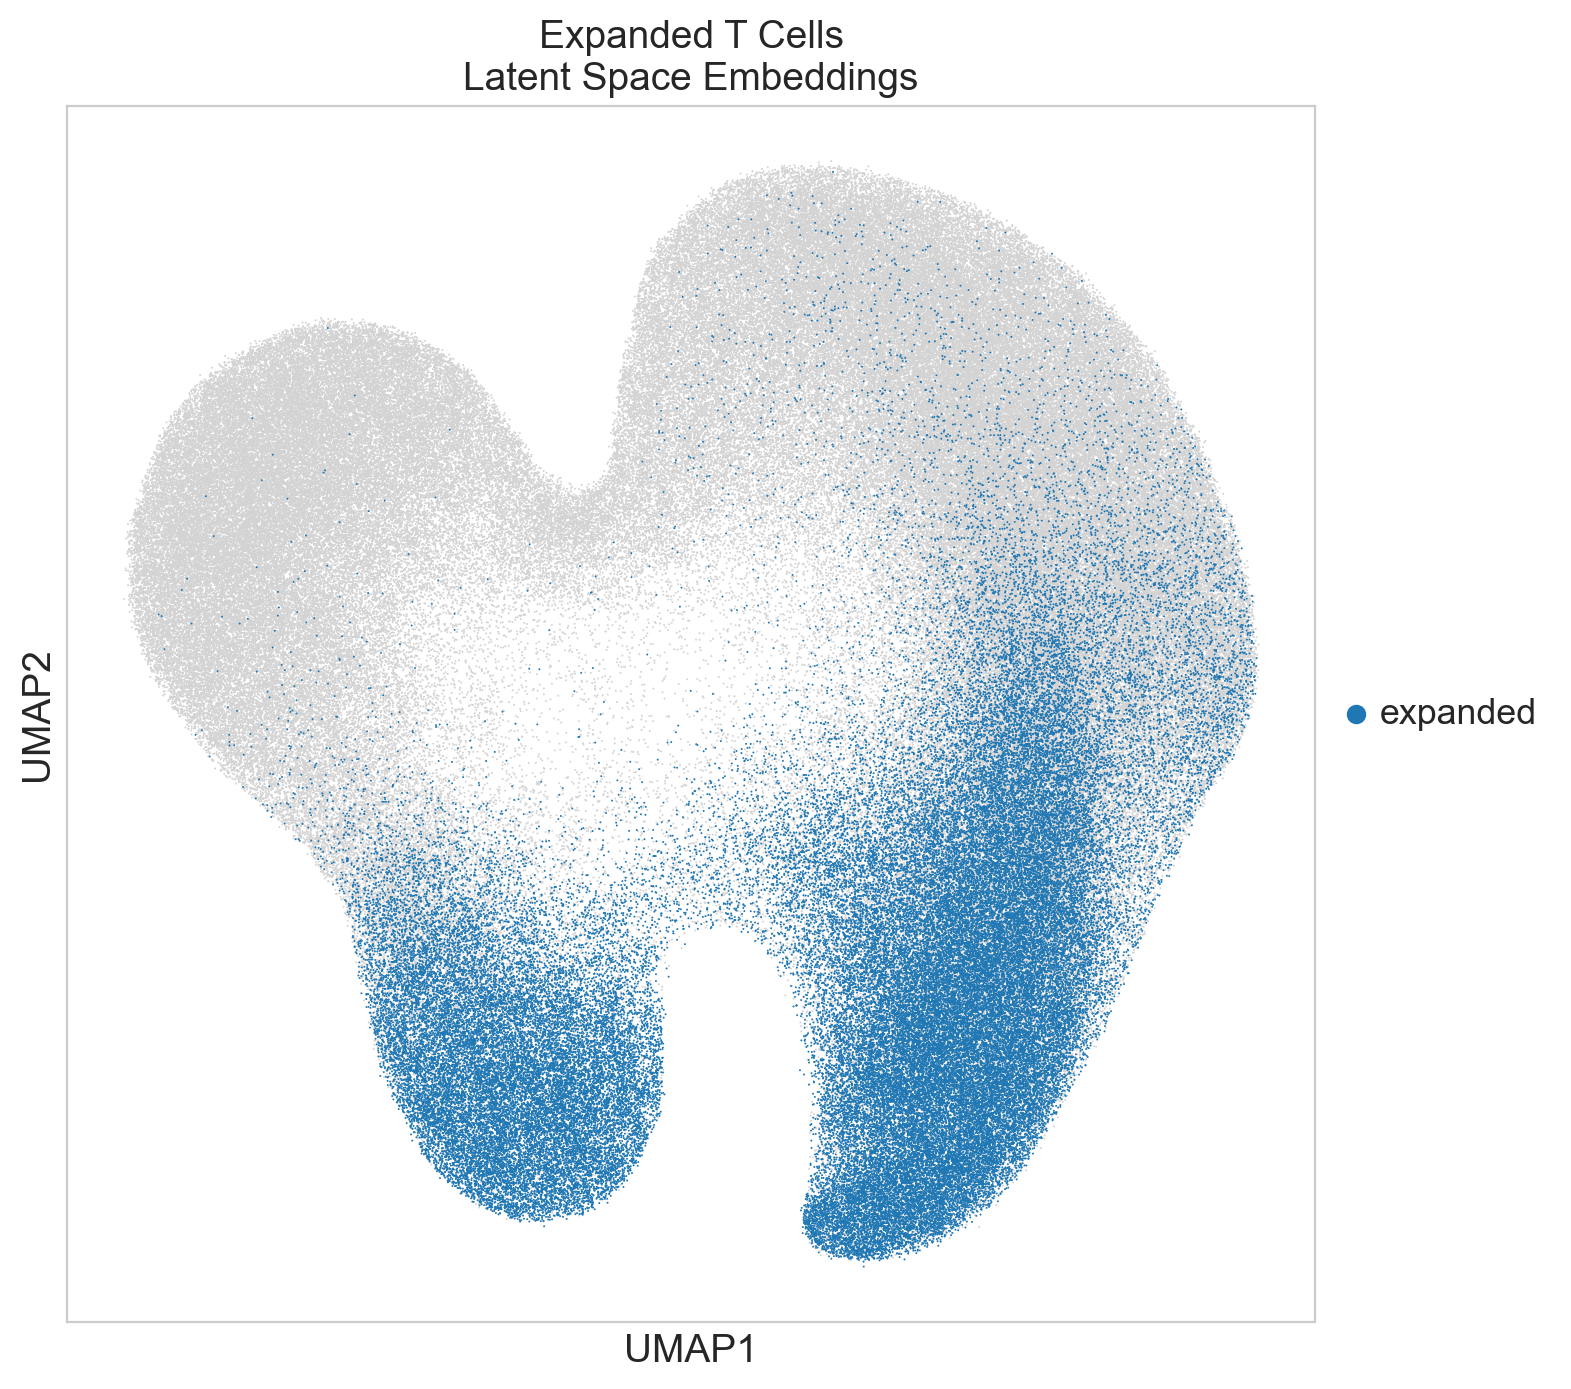

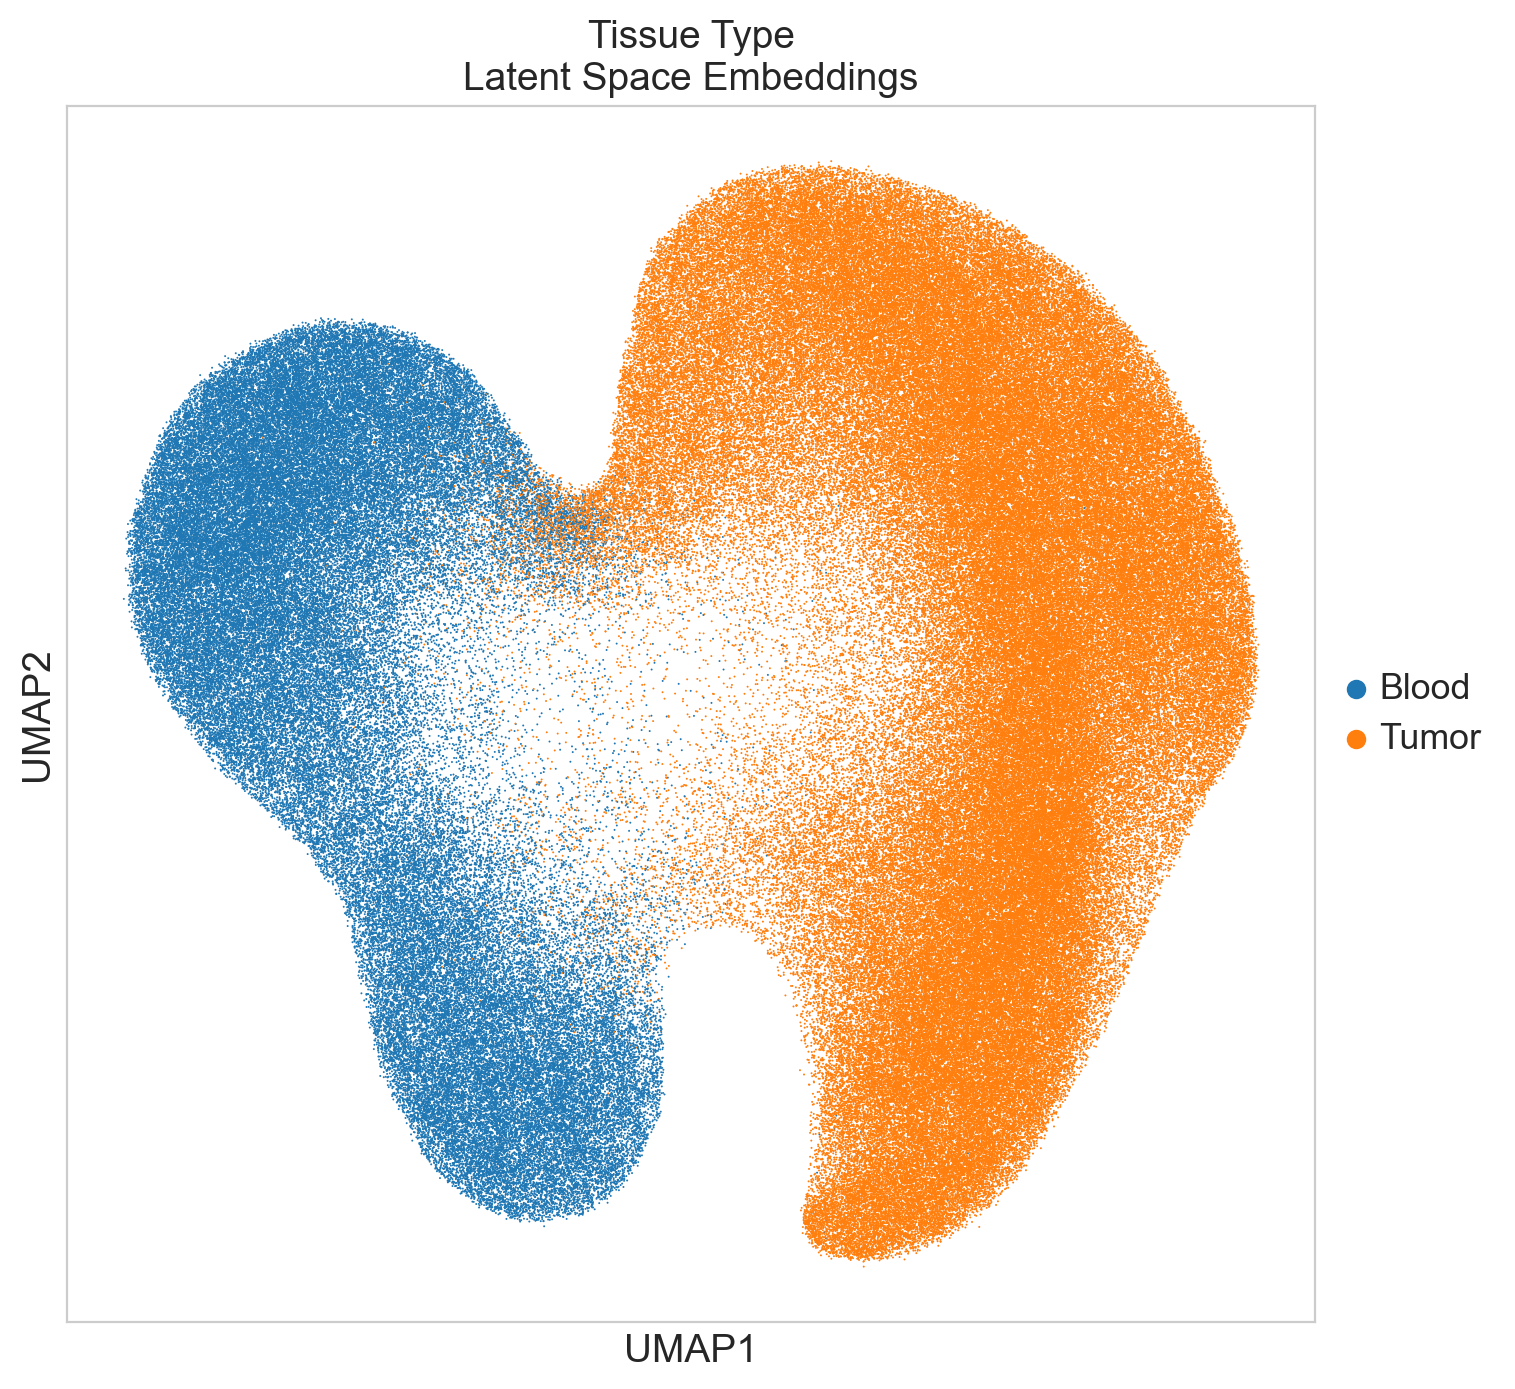

In [11]:
if "expansion" in emb_adata.obs:
    sc.pl.umap(
        emb_adata,
        color=["expansion"],
        title="Expanded T Cells\nLatent Space Embeddings",
        groups=["expanded"],
        na_in_legend=False,
        size=2,
    )
if "tissue_type" in emb_adata.obs:
    sc.pl.umap(emb_adata, color=["tissue_type"], title="Tissue Type\nLatent Space Embeddings", size=2)

 ## Save UMAP Coordinates with Metadata

In [12]:
# Create a DataFrame with UMAP coordinates and metadata
umap_df = pd.DataFrame(emb_adata.obsm["X_umap"], columns=["UMAP1", "UMAP2"])
if "tissue_type" in emb_adata.obs:
    umap_df["tissue_type"] = emb_adata.obs["tissue_type"]

if "imputed_labels" in emb_adata.obs:
    umap_df["expansion"] = emb_adata.obs["expansion"]

# Save to CSV
umap_df.to_csv(SAVE_PATH / "umap_coordinates_with_metadata.csv", index=False)
print(f"Saved UMAP coordinates with metadata to {SAVE_PATH / 'umap_coordinates_with_metadata.csv'}")

Saved UMAP coordinates with metadata to c:\Users\Ron\repos\scXpand\results\embeddings_visualization_v_1\umap_coordinates_with_metadata.csv
